# Method 3: keras_ocr

### 3. Keras-OCR
**The "Scene Text" Specialist**

* **What it is:** A Deep Learning model built on TensorFlow and Keras. It combines a detector (CRAFT) and a recognizer (CRNN), similar to EasyOCR but implemented differently.
* **Best for:**
    * **Irregular Text:** Excellent at reading curved, rotated, or oddly shaped text.
    * **Customization:** Easier to retrain or fine-tune if you are already comfortable with Keras/TensorFlow.
* **Weaknesses:**
    * **English-Centric:** Out of the box, it is primarily designed for English and numbers. Adding other languages (like Khmer) requires significant effort and retraining.
    * **Dependencies:** As you experienced, it can have strict dependency requirements with specific versions of TensorFlow and NumPy.

In [1]:
import keras_ocr
import cv2
import numpy as np
import matplotlib.pyplot as plt

Looking for /Users/hkm/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/hkm/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 6s 6s/step


/opt/anaconda3/envs/keras_ocr/lib/python3.10/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/opt/anaconda3/envs/keras_ocr/lib/python3.10/site-packages/shapely/constructive.py:1353: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


3/3 [==============================] - 3s 723ms/step
Final extracted text:

ciessmstes
data
bos
one page handwriting
once there was a dog
he was very hungry
he found a piece of meat
he reaches on d bank of river
he saw his shadow in the water
he thought there was anothex
dog ln water he became
greedy he barked to shadow
to get meat his piece of
meat fell down in water
he lost his piece of meat


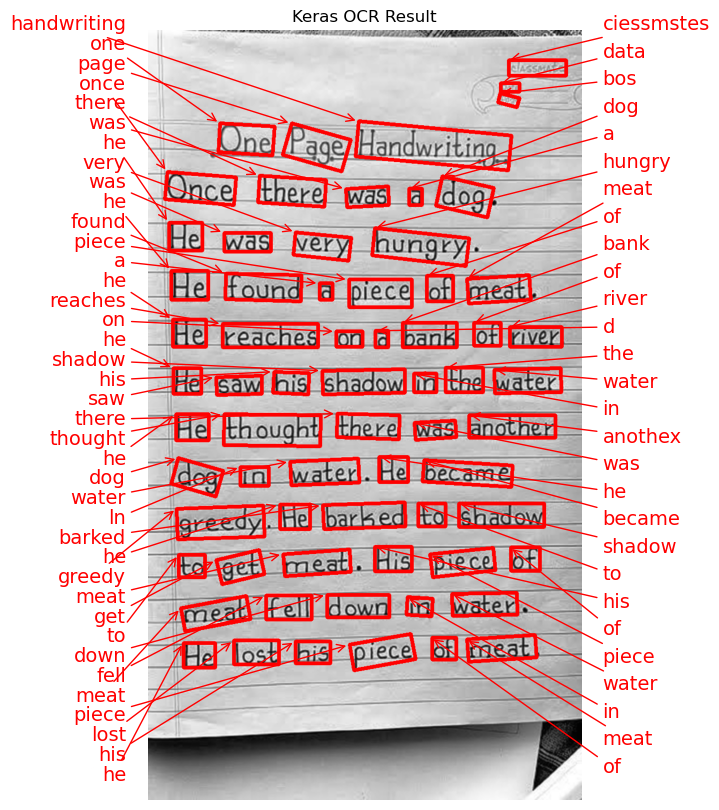

In [4]:
# ---------- PREPROCESSING ----------
def preprocess_for_ocr(image_path):
    img = cv2.imread(image_path)

    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return rgb


# ---------- NEW ADD: SORT INTO LINES ----------
def sort_into_lines(results, y_threshold=20):
    lines = []

    for text, box in results:
        y_center = np.mean(box[:, 1])
        placed = False

        for line in lines:
            if abs(line["y"] - y_center) < y_threshold:
                line["items"].append((text, box))
                placed = True
                break

        if not placed:
            lines.append({
                "y": y_center,
                "items": [(text, box)]
            })

    lines = sorted(lines, key=lambda l: l["y"])

    sorted_lines = []
    for line in lines:
        items = sorted(
            line["items"],
            key=lambda x: np.min(x[1][:, 0])
        )
        sorted_lines.append(items)

    return sorted_lines


# ---------- LOAD MODEL ----------
pipeline = keras_ocr.pipeline.Pipeline()


# ---------- IMAGE PATH ----------
image_path = "image_ocr/image1.jpg"


# ---------- PREPROCESS IMAGE ----------
image = preprocess_for_ocr(image_path)


# ---------- OCR ----------
raw_results = pipeline.recognize([image])[0]

# convert to (text, box) format
results = [(text, box) for text, box in raw_results]


# ---------- NEW ADD: EXTRACT SENTENCES ----------
lines = sort_into_lines(results)

print("Final extracted text:\n")
for line in lines:
    sentence = " ".join([text for text, _ in line])
    print(sentence)


# ---------- VISUALIZE RESULT ----------
fig, ax = plt.subplots(figsize=(10, 10))

keras_ocr.tools.drawAnnotations(
    image=image,
    predictions=raw_results,
    ax=ax
)

ax.set_title("Keras OCR Result")
plt.axis("off")
plt.show()
